## 序列模型
**锚定效应(anchoring):** 基于其他人的意见作出评价.结果表明,这种效应会使评分提高半个百分点以上\

**享乐适应(hedonic adaption):** 人们迅速接受并且适应一种更好或者更坏的情况作为新的常态. 例如:看了好多精彩的电影,即使是普通的电影,人们也可能认为是糟糕的\

**季节性(seasonality):** 少有观众喜欢在八月看圣诞老人的电影.\
**...**\
综上,一个电影的好与坏有很多因素决定,因此使用时间动力学可以得到更准确的电影推荐.
序列数据不仅仅是关于电影评分的:
* 使用APP时,当学生放学后社交媒体APP用的较多,而市场开放式,炒股APP更多
* 音乐,语音,文本和视频都是连续的,他们的序列被我们重排,那么就会失去原有的意义,例如"人咬狗"和"狗咬人"

### 统计工具

处理序列数据需要统计工具和新的神经网络架构.
假如:我们已知x1,x2,x3...,xn-1这n-1天的股票数据,现在想要预测xn这一天的数据.有一下两种策略:
* 1.可能x1..xn-1这n-1天的数据并非全部有用,而是一定时间范围$\tau$这个跨度即可,即使用xn-1....xn-t即可,这个策略的好处是参数的总量是不变的,至少当t>tau时, 这种模型被称为**自回归模型(autoregressive models)**,因为他们是对自己执行回归.
* 2. 如下图所示,是保留一些对过去观测的总结ht,并且同时更新预测xt^和ht, 这就产生了基于xt^ = P(xt|ht)来估计xt,以及公式ht=g(ht-1,xt-1)更新的模型.由于ht从未被观测到,这类模型也被称为**隐变量自回归模型**\
![](img/2022-05-02-16-01-03.png)

### 马尔科夫模型(Markov Model)

在自回归模型AutoRegression中,使用长度为tau的序列而非全部数据来预测新的结果,只要这种是近似精确的,我们就说序列满足Markov Condition,如果tau=1 得到一个 **一阶马尔科夫模型(first-order Markov Model)** P(x)由下式给出:
![](img/2022-05-02-16-19-24.png)

## 训练

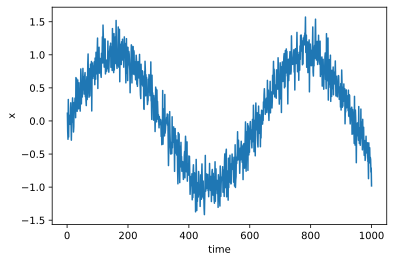

In [2]:
import matplotlib_inline 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from icecream import ic
import sys,os
sys.path.append(os.path.abspath("../"))
import lmy
import d2l
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
T = 1000 # 总共产生一千个点
time = torch.arange(1,T+1,dtype=torch.float32)
x = torch.sin(0.01*time) + torch.normal(0,0.2,(T,)) # 加噪音
plt.xlabel("time")
plt.ylabel("x")
plt.plot(time.numpy(),x.numpy())

接下来,我们将这个序列转换为模型的特征-标签对,基于嵌入的维度tau,我们将数据映射为数据对yt=xt,Xt=[xt-tau,...xt-1]

In [3]:
tau = 4 # 设置维度为4, 每个数据只与前四个相关
features = torch.zeros((T-tau,tau))
for i in range(tau):
    features[:,i] = x[i:i+T-tau]
labels = x[tau:].reshape((-1,1))
ic(features.shape,labels.shape)
batch_size = 16
num_train = 600
train_iter = lmy.load_array((features[:num_train],labels[:num_train]),batch_size,is_train=True)

ic| features.shape: torch.Size([996, 4])
    labels.shape: torch.Size([996, 1])


数据加载完成


In [4]:
# 设计一个简单的MLP
class MLP(nn.Module):
    @staticmethod
    def init_weights(m):
        """权重初始化函数"""
        if type(m) == nn.Linear:
            nn.init.xavier_normal_(m.weight)

    def __init__(self, tau):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(tau, 10), nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.net.apply(self.init_weights)

    def forward(self, x):
        return self.net(x)


In [5]:
net = MLP(4)
loss = nn.MSELoss(reduction='none')

def train(net,train_iter,loss,epochs,lr):
    trainer = torch.optim.Adam(net.parameters(),lr=lr)
    for epoch in range(epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.sum().backward()
            trainer.step()
        print("epoch:",epoch+1,"loss:",d2l.evaluate_loss(net,train_iter,loss))

train(net,train_iter,loss,10,0.01)

epoch: 1 loss: 0.056655904402335484
epoch: 2 loss: 0.0618597603837649
epoch: 3 loss: 0.05189146692554156
epoch: 4 loss: 0.0505004466076692
epoch: 5 loss: 0.049915400507549446
epoch: 6 loss: 0.052973914196093874
epoch: 7 loss: 0.05181909034649531
epoch: 8 loss: 0.058358068466186526
epoch: 9 loss: 0.05183009733756383
epoch: 10 loss: 0.05298135673006376


ic| onestep_preds.shape: torch.Size([996, 1])
    labels.shape: torch.Size([996, 1])


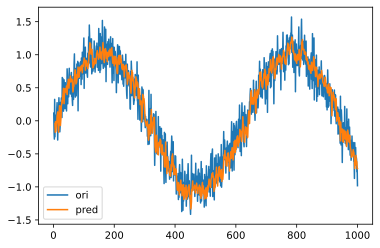

In [10]:
onestep_preds = net(features)
ic(onestep_preds.shape,labels.shape)
plt.plot(time.numpy(),x.numpy())
plt.plot(time[tau:].numpy(),onestep_preds.detach().numpy())
plt.legend(["ori","pred"])

如果我们只有600个数据,那么我们最多只能预测到604,但是如果我们想要预测605等往后的数据,这些新预测数据便建立在我们预测的基础上了,效果测试:

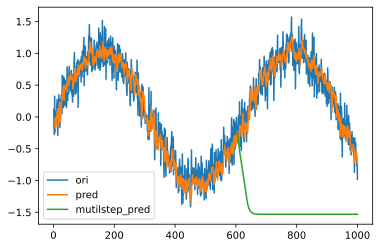

In [12]:
multistep_preds = torch.zeros(T)
multistep_preds[: num_train + tau] = x[: num_train + tau]
for i in range(num_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))
plt.plot(time.numpy(),x.numpy())
plt.plot(time[tau:].numpy(),onestep_preds.detach().numpy())
plt.plot(time[num_train + tau:],multistep_preds[num_train + tau:].detach().numpy())
plt.legend(["ori","pred","mutilstep_pred"])


从下图中,我们很容易发现,当步数越大时,我们预测的也更加不准确,单步数越少,预测的算力消耗更多
![](img/2022-05-02-18-35-23.png)